In [1]:
import os
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline
import csv
import pandas as pd
import skrf as rf

#define the targeted max frequency
fmax = 196
#define function for loading images and s-parameters
#"path" is the path for images of transformer layout
#"label" is the path for labels. In this case, labels are S-parameter associated with each images 
def load_images_from_path(path, label,length):
    images = []
    labels = []
    
    for i in range(length):
        #load images
        img = image.load_img(path+str(i)+'.png', target_size=(500, 500, 3))
        images.append(image.img_to_array(img)[138:362,138:362,:])#trim the ground margin

        #load S-parameters
        #According to symmerty, only S11,S12,S13,S14,S33,S34 are considered
        #Each S-parameter has real and imaginary parts, and hence 12 real values in total.
        results = []
        datafile = label+str(i)+".s4p"
        spt = rf.Network(datafile)
        for i in range(fmax+1):
            results.append([spt.s[i][0][0].real,spt.s[i][0][0].imag,
                            spt.s[i][0][1].real,spt.s[i][0][1].imag,
                            spt.s[i][0][2].real,spt.s[i][0][2].imag,
                            spt.s[i][0][3].real,spt.s[i][0][3].imag,
                            spt.s[i][2][2].real,spt.s[i][2][2].imag,
                            spt.s[i][2][3].real,spt.s[i][2][3].imag])      
        labels.append(results) 
    return images, labels

def show_images(images):
    fig, axes = plt.subplots(1, 8, figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i] / 255)

2024-12-03 10:13:45.908346: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

(1923, 12)


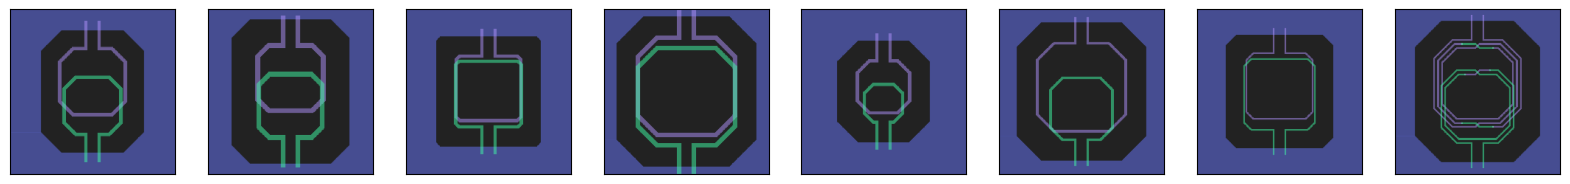

In [3]:
#load data
#geometrical parameters stored in log.txt
#order of geopara (radiusA,radiusB,turnsA,turnsB,openA,openB,outA,outB,extA,extB,ratio,outbound)
logfile = open("/rdf/shared/design_automation/Data/2409/log.txt","r")
listall = list(map(lambda item: list(map(lambda jtem: eval(jtem.strip()), item[1:-1].split(','))), logfile.read().strip().split('\n')))
tabular_data = np.array(listall)

#load images and s-parameters
length = 4100
images, labels = load_images_from_path('/rdf/shared/design_automation/Data/2409/PNG/', '/rdf/shared/design_automation/Data/2409/SPData/',length)
show_images(images)
geoparas = []
images11 = []
labels11 = []

for kk in range(length):
    #select 1 turn and 1 turn transformers
   if((tabular_data[kk,2] !=1) or (tabular_data[kk,3]!=1)):
       #geoparas only includes the variable parameters in our designs. 
       #Constants at this design stages are excluded 
        geoparas.append(tabular_data[kk,(0,1,2,3,4,5,4,5,6,7,12,13)])
        images11.append(images[kk])
        labels11.append(labels[kk])
print(np.shape(geoparas))

In [4]:
#load data from the second folder
#geometrical parameters stored in log.txt
#order of geopara (radiusA,radiusB,turnsA,turnsB,openA,openB,outA,outB,extA,extB,ratio,outbound)
logfile = open("/rdf/shared/design_automation/Data/2409_2/log.txt","r")
listall = list(map(lambda item: list(map(lambda jtem: eval(jtem.strip()), item[1:-1].split(','))), logfile.read().strip().split('\n')))
tabular_data = np.array(listall)

#load images and s-parameters
#length = len(listall)-3
length = 2500
images, labels = load_images_from_path('/rdf/shared/design_automation/Data/2409_2/PNG/', '/rdf/shared/design_automation/Data/2409_2/SPData/',length)


for kk in range(length):
    #select 1 turn and 1 turn transformers
   if((tabular_data[kk,2] !=1) or (tabular_data[kk,3]!=1)):
       #geoparas only includes the variable parameters in our designs. 
       #Constants at this design stages are excluded 
        geoparas.append(tabular_data[kk,(0,1,2,3,4,5,4,5,6,7,12,13)])
        images11.append(images[kk])
        labels11.append(labels[kk])
print(np.shape(geoparas))

(3949, 12)


In [5]:
#normalize geometrical inputs
geoparas_temp = np.array(geoparas)
geoparas = np.zeros(np.shape(geoparas_temp))
for i in range(len(geoparas)):
    for j in range(12):
        geoparas[i,j]= (geoparas_temp[i,j]-np.mean(geoparas_temp[:,j]))/np.std(geoparas_temp[:,j])

In [6]:
#construct the datasets
class item:
  def __init__(self, image,geopara,label ):
    self.image = image
    self.geopara = geopara
    self.label = label

data = []
for i in range(len(images11)):
    data.append(item(images11[i],geoparas[i],labels11[i]))

np.random.shuffle(data)

In [7]:
#define the split length for training, validation and test datasets
length = len(images11)
split1 = int(0.6*length)
split2 = int(0.8*length)
data_train = data[0:split1]
data_valid = data[split1:split2]
data_test = data[split2:]

In [8]:
#Separate the training, validation and test datasets 
train_images = []
train_labels = []
train_geoparas = []
valid_images = []
valid_labels = []
valid_geoparas = []
test_images = []
test_labels = []
test_geoparas = []


#The targeted frequency span up to fmax, with 1GHz step
s_max = np.zeros((fmax,12))
s_min = np.zeros((fmax,12))
srange = np.zeros((fmax,12))


for i in range(len(data_train)):
    train_images.append(data_train[i].image)
    train_geoparas.append(data_train[i].geopara)
    train_labels.append(data_train[i].label)
x_train_img = np.array(train_images) / 255
x_train_geopara = np.array(train_geoparas)
y_train_encoded = np.array(train_labels)[:,1:fmax+1,:]


for i in range(len(data_valid)):
    valid_images.append(data_valid[i].image)
    valid_geoparas.append(data_valid[i].geopara)
    valid_labels.append(data_valid[i].label)
x_valid_img = np.array(valid_images) / 255
x_valid_geopara = np.array(valid_geoparas)
y_valid_encoded = np.array(valid_labels)[:,1:fmax+1,:]


for i in range(len(data_test)):
    test_images.append(data_test[i].image)
    test_geoparas.append(data_test[i].geopara)
    test_labels.append(data_test[i].label)
x_test_img = np.array(test_images) / 255
x_test_geopara = np.array(test_geoparas)
y_test_encoded = np.array(test_labels)[:,1:fmax+1,:]

#normalize the s-parameters for each frequency point
for z in range(fmax):
    for i in range(12):
        s_max[z,i] = max(max(y_train_encoded[:,z,i]),max(y_valid_encoded[:,z,i]),max(y_test_encoded[:,z,i]))
        s_min[z,i] = min(min(y_train_encoded[:,z,i]),min(y_valid_encoded[:,z,i]),min(y_test_encoded[:,z,i]))
        srange[z,i] = s_max[z,i]-s_min[z,i]
    
    for i in range(12):
        y_train_encoded[:,z,i] = 2*(y_train_encoded[:,z,i]-s_min[z,i])/srange[z,i]-1

    for i in range(12):
        y_valid_encoded[:,z,i] = 2*(y_valid_encoded[:,z,i]-s_min[z,i])/srange[z,i]-1
    
    for i in range(12):
        y_test_encoded[:,z,i] = 2*(y_test_encoded[:,z,i]-s_min[z,i])/srange[z,i]-1

In [9]:
def custom_loss(y_true, y_pred):
    Lf = tf.math.sqrt(tf.reduce_mean(tf.square(y_true - y_pred),axis=1))
    return (tf.reduce_mean(Lf))

In [10]:
from keras import Sequential, Input, Model, regularizers
from keras.layers import Conv2D, MaxPooling2D,Dropout, Reshape, BatchNormalization,Conv1DTranspose,Conv1D
from keras.layers import Flatten, Dense, Concatenate
learning_rate = 2e-4
n_unet = 8

models = []

inp1 = Input((224,224,3),)
'''
model1 = (Conv2D(n_unet,(3,3),padding='same', activation='relu', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l2(0.01)))(inp1)
model1 = (MaxPooling2D(2, 2))(model1)
model1 = (Conv2D(n_unet*2, (3, 3), padding='same',activation='relu'))(model1)

model1 = (MaxPooling2D(2, 2))(model1)
#model1 = BatchNormalization()(model1)
model1 = (Conv2D(n_unet*2, (3, 3),  padding='same',activation='relu'))(model1)

model1 = (MaxPooling2D(2, 2))(model1)
#model1 = BatchNormalization()(model1)
model1 = (Conv2D(n_unet*4, (3, 3), padding='same', activation='relu'))(model1)

layer1 = (MaxPooling2D(2, 2))(model1)
#model1 = Dropout(0.3)(model1)
#model1 = BatchNormalization()(model1)
layer2 = (Conv2D(n_unet*8, (3, 3),padding='same', activation='relu'))(layer1)
layer2 = (MaxPooling2D(2, 2))(layer2)

layer3 = (Conv2D(n_unet*16, (3, 3),padding='same', activation='relu'))(layer2)
layer3 = (MaxPooling2D(2, 2))(layer3)

layer4 = (Conv2D(n_unet*32, (3, 3),padding='same', activation='relu'))(layer3)
layer4 = (MaxPooling2D(2, 2))(layer4)


#backward
layer4 = Reshape((1,n_unet*32))(layer4)
layer4 = (Conv1DTranspose(n_unet*16,9,1, activation='relu'))(layer4)

layer3 = Reshape((9,n_unet*16))(layer3)
layer3 = Concatenate()([layer3,layer4])
layer3 = (Conv1D(n_unet*16,3,padding='same', activation='relu'))(layer3)
layer3 = (Conv1DTranspose(n_unet*8,9,5, activation='relu'))(layer3)


layer2 = Reshape((49,n_unet*8))(layer2)
layer2 = Concatenate()([layer2,layer3])
layer2 = (Conv1D(n_unet*8,3,padding='same', activation='relu'))(layer2)
layer2 = (Conv1DTranspose(n_unet*4,3,4, activation='relu'))(layer2)

layer1 = Reshape((196,n_unet*4))(layer1)
layer1 = Concatenate()([layer1,layer2])
layer1 = (Conv1D(n_unet*4,3,padding='same', activation='relu'))(layer2)
model1 = Flatten()(layer1)
models.append(model1)
'''
inp2 = Input(12,)
'''
model2=(Dense(512,activation='relu',input_shape = (8,),kernel_regularizer=regularizers.l2(0.10)))(inp2)
model2=(Dense(512,activation='relu'))(model2)
model2=(Dense(512,activation='relu'))(model2)
model2=(Dense(512,activation='relu'))(model2)
model2=(Dense(512,activation='relu'))(model2)
models.append(model2)
'''
model3 = (Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l2(0.05)))(inp1)
model3 = (MaxPooling2D(2, 2))(model3)
model3 = (Conv2D(128, (3, 3), activation='relu'))(model3)

model3 = (MaxPooling2D(2, 2))(model3)
#model1 = BatchNormalization()(model1)
model3 = (Conv2D(128, (3, 3), activation='relu'))(model3)

model3 = (MaxPooling2D(2, 2))(model3)
#model1 = BatchNormalization()(model1)
model3 = (Conv2D(128, (3, 3), activation='relu'))(model3)

model3 = (MaxPooling2D(2, 2))(model3)
#model1 = Dropout(0.3)(model1)
#model1 = BatchNormalization()(model1)
model3 = (Conv2D(128, (3, 3), activation='relu'))(model3)

model3 = (MaxPooling2D(2, 2))(model3)
#model1 = BatchNormalization()(model1)
#model1 = Dropout(0.3)(model1)
model3 = Flatten()(model3)
model3 = Dense(512,activation='relu')(model3)

models.append(model3)
out = Concatenate()(models)

out = (Dense(fmax*12, activation='tanh'))(out)
out = Reshape((fmax,12))(out)
model = Model([inp1,inp2],out)
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=learning_rate), loss=custom_loss, metrics=['mae',custom_loss])
model.summary()

2024-12-03 10:16:43.119274: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13397 MB memory:  -> device: 0, name: NVIDIA A2, pci bus id: 0000:21:00.0, compute capability: 8.6


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 222, 222, 32)         896       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 109, 109, 128)        36992     ['max_pooling2d[0][0]']   

In [11]:
model.load_weights('./models/air/mturn_196G_CNN.h5')
EPOCHS = 150
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: learning_rate * 0.95**(epoch/20))
hist = model.fit([x_train_img,x_train_geopara], y_train_encoded, validation_data=([x_valid_img,x_valid_geopara], y_valid_encoded), batch_size=30, epochs = EPOCHS,callbacks=[lr_schedule])

Epoch 1/150


2024-12-03 10:16:47.974517: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2024-12-03 10:16:48.103212: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-12-03 10:16:48.993714: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-12-03 10:16:49.067578: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f3168269b50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-03 10:16:49.067646: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A2, Compute Capability 8.6
2024-12-03 10:16:49.077911: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-03 10:16:49.176597: I tensorflo

79/79 [==============================] - 18s 140ms/step - loss: 0.3298 - mae: 0.2700 - custom_loss: 0.3230 - val_loss: 0.2767 - val_mae: 0.2222 - val_custom_loss: 0.2701 - lr: 2.0000e-04
Epoch 2/150
79/79 [==============================] - 7s 87ms/step - loss: 0.2575 - mae: 0.2051 - custom_loss: 0.2512 - val_loss: 0.2347 - val_mae: 0.1855 - val_custom_loss: 0.2287 - lr: 1.9949e-04
Epoch 3/150
79/79 [==============================] - 7s 90ms/step - loss: 0.2215 - mae: 0.1739 - custom_loss: 0.2155 - val_loss: 0.2097 - val_mae: 0.1634 - val_custom_loss: 0.2041 - lr: 1.9898e-04
Epoch 4/150
79/79 [==============================] - 8s 97ms/step - loss: 0.1990 - mae: 0.1548 - custom_loss: 0.1932 - val_loss: 0.1923 - val_mae: 0.1487 - val_custom_loss: 0.1868 - lr: 1.9847e-04
Epoch 5/150
79/79 [==============================] - 7s 87ms/step - loss: 0.1841 - mae: 0.1424 - custom_loss: 0.1785 - val_loss: 0.1828 - val_mae: 0.1404 - val_custom_loss: 0.1774 - lr: 1.9796e-04
Epoch 6/150
79/79 [======

In [12]:
np.shape(y_train_encoded) 

(2369, 196, 12)

In [13]:
test_prediction = model.predict([x_test_img,x_test_geopara])

25/25 [==============================] - 2s 52ms/step


In [14]:
np.shape(test_prediction)

(790, 196, 12)

[]

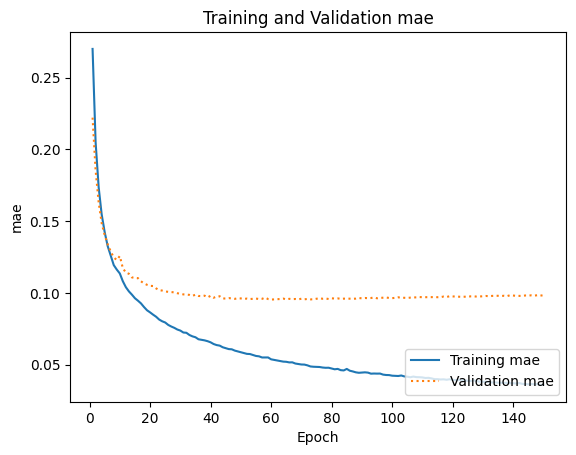

In [15]:
mae = hist.history['mae']
val_mae = hist.history['val_mae']
epochs = range(1, len(mae) + 1)

plt.plot(epochs, mae, '-', label='Training mae')
plt.plot(epochs, val_mae, ':', label='Validation mae')
plt.title('Training and Validation mae')
plt.xlabel('Epoch')
plt.ylabel('mae')
plt.legend(loc='lower right')
plt.plot()

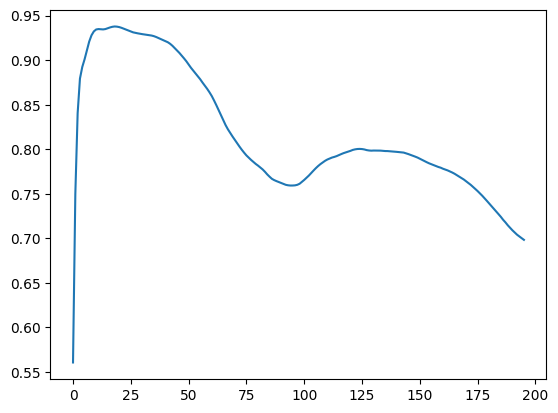

In [16]:
from sklearn.metrics import r2_score
r2_result = []
for z in range(fmax):
    r2 = 0
    for i in range(12):
        temp = r2_score(y_test_encoded[:,z,i], test_prediction[:,z,i], force_finite=False)
        r2 = r2+temp
    r2_result.append(r2/12)
plt.plot(range(fmax),r2_result)

In [17]:
np.mean(r2_result)

0.8174301634625186

In [18]:
mae_all = np.zeros((fmax,12))
mae_mean = np.zeros(fmax)
for z in range(fmax):
    for i in range(12):
        mae_all[z][i] = np.mean(abs(test_prediction[:,z,i]-y_test_encoded[:,z,i]))*0.5*srange[z,i]
    mae_mean[z] = np.mean(mae_all[z][:])

Text(0, 0.5, 'S-parameter mae')

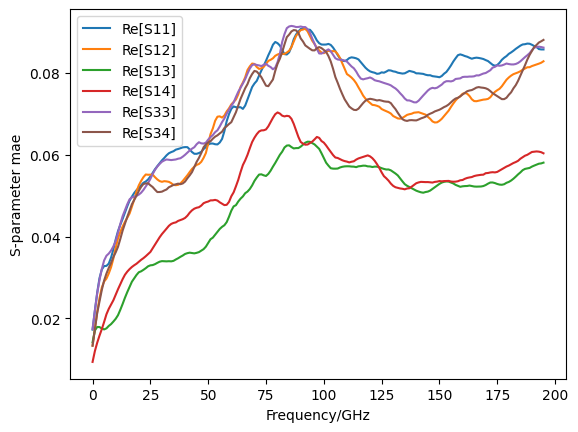

In [19]:
freq = range(fmax)
for i in range(12):
    if (i%2==0):
        plt.plot(freq,mae_all[:,i])
plt.legend(["Re[S11]","Re[S12]","Re[S13]","Re[S14]","Re[S33]","Re[S34]"])
plt.xlabel('Frequency/GHz')
plt.ylabel('S-parameter mae')

In [20]:
mae_all = np.zeros((fmax,12))
mae_mean = np.zeros(fmax)
for z in range(fmax):
    for i in range(12):
        mae_all[z][i] = np.mean(abs(test_prediction[:,z,i]-y_test_encoded[:,z,i]))*0.5*srange[z,i]
    mae_mean[z] = np.mean(mae_all[z][:])

Text(0, 0.5, 'Average S-parameter mae')

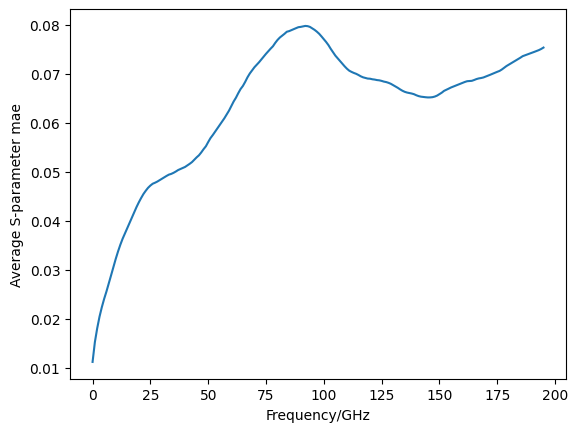

In [21]:
plt.plot(range(fmax),mae_mean)
plt.xlabel('Frequency/GHz')
plt.ylabel('Average S-parameter mae')

Text(0, 0.5, 'S-parameter mae')

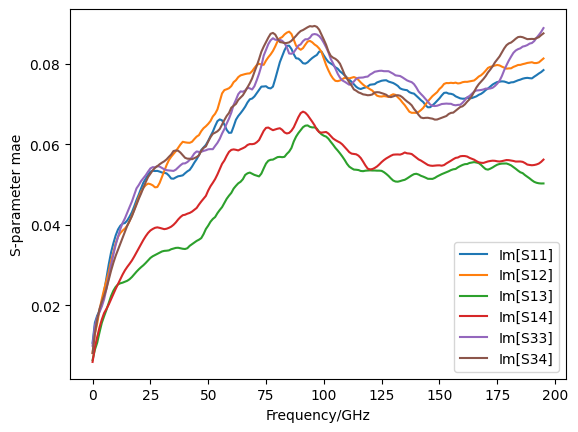

In [22]:
freq = range(fmax)
for i in range(12):
    if (i%2==1):
        plt.plot(freq,mae_all[:,i])
plt.legend(["Im[S11]","Im[S12]","Im[S13]","Im[S14]","Im[S33]","Im[S34]"])        
plt.xlabel('Frequency/GHz')
plt.ylabel('S-parameter mae')

In [23]:
np.mean(mae_mean)

0.0630431772966355

In [24]:
def R_squared(y, y_pred):
  residual = tf.reduce_sum(tf.square(tf.subtract(y, y_pred)))
  total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
  r2 = tf.subtract(1.0, tf.divide(residual, total))
  return r2
print(R_squared(y_test_encoded,test_prediction))

tf.Tensor(0.8820896788098598, shape=(), dtype=float64)


In [25]:
model.save('./models/substrate/mturn_196G_CNN.h5')

/home/hh68/.conda/envs/tensorflow/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:
np.save('MAE_CNN.npy',mae_all)